
<img src="../../img/ods_stickers.jpg">

## <center> [mlcourse.ai](https://mlcourse.ai) – открытый курс OpenDataScience по машинному обучению 
    
Автор материала: Виталий Радченко, Data scientist @ YouScan (@vradchenko в Slack ODS). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала

# <center> Домашнее задание № 5 (Демо).
## <center> Логистическая регрессия и случайный лес в задаче кредитного скоринга

[Веб-форма](https://docs.google.com/forms/d/1HASy2b_FLBHBCzzpG-TbnbB6gqhB-qwznQxU2vaoSgc/) для ответов.

#### Нашей главной задачей будет построение модели для задачи кредитного скоринга.

Но для разминки решите первое задание :)

**Задание 1.** В зале суда есть 5 присяжных, каждый из них по отдельности с вероятностью 70% может правильно определить, виновен подсудимый или нет. С какой вероятностью они все вместе вынесут правильный вердикт, если решение принимается большинством 
голосов?

- 70.00%
- 83.20%
- 83.70%
- 87.50%

**Решение:**
Решение будет верным, в том случае, когда правильно ответят 3 или 4 или 5 из 5, другими словами:
${C^{3}_5 * 0.7^3 + C^{4}_5 * 0.7^4 + C^{5}_5 * 0.7^5 \approx   0.837 }$

**Ответ:** 83.70%

Теперь перейдем непосредственно к машинному обучению.

#### Данные представлены следующим образом:

##### Прогнозируемая  переменная
* SeriousDlqin2yrs	      – Человек не выплатил данный кредит в течение 90 дней; возможные значения  1/0 

##### Независимые признаки
* age	                          –  Возраст заёмщика кредитных средств; тип - integer
* NumberOfTime30-59DaysPastDueNotWorse	 – Количество раз, когда человек имел просрочку выплаты других кредитов более 30-59 дней, но не больше в течение последних двух лет; тип -	integer
* DebtRatio  – 	Ежемесячный отчисления на задолжености(кредиты,алименты и т.д.)  / совокупный месячный доход 	percentage; тип -	real
* MonthlyIncome	 – Месячный доход в долларах; тип -	real
* NumberOfTimes90DaysLate  – Количество раз, когда человек имел просрочку выплаты других кредитов более 90 дней; тип -	integer
* NumberOfTime60-89DaysPastDueNotWorse – 	Количество раз, когда человек имел просрочку выплаты других кредитов более 60-89 дней, но не больше в течение последних двух лет; тип -	integer
* NumberOfDependents  – Число человек в семье кредитозаёмщика; тип -	integer

In [255]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import warnings
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from __future__ import division, print_function

%matplotlib inline
%pylab inline
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


In [3]:
## Сделаем функцию, которая будет заменять NaN значения на медиану в каждом столбце таблицы
def delete_nan(table):
    for col in table.columns:
        table[col] = table[col].fillna(table[col].median())
    return table

In [4]:
## Считываем данные
data = pd.read_csv("./../data/credit_scoring_sample.csv", sep=";")
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [5]:
## Рассмотрим типы считанных данных
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Distribution of target


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

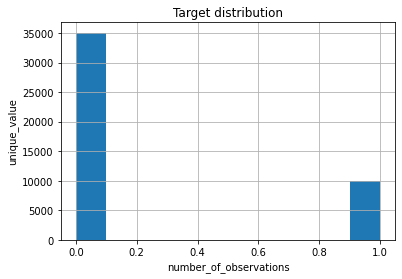

In [6]:
## Посмотрим на распределение классов в зависимой переменной

ax = data["SeriousDlqin2yrs"].hist(orientation="vertical")
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print("Distribution of target")
data["SeriousDlqin2yrs"].value_counts() / data.shape[0]

In [7]:
## Выберем названия всех признаков из таблицы, кроме прогнозируемого

independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != "SeriousDlqin2yrs"]
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

In [8]:
## Применяем функцию, заменяющую все NaN значения на медианное значение соответствующего столбца
table = delete_nan(data)

In [9]:
## Разделяем таргет и признаки
X = table[independent_columns_names]
y = table["SeriousDlqin2yrs"]

# Бутстрэп

**Задание 2.** Сделайте интервальную оценку среднего возраста (age) для клиентов, которые просрочили выплату кредита, с 90% "уверенностью". Используйте пример из статьи, поставьте `np.random.seed(0)`, как это сделано в статье.

In [268]:
def get_bootstrap_samples(data, n_samples):
    # функция для генерации подвыборок с помощью бутстрэпа
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    # функция для интервальной оценки
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [269]:
overduers = data[data['SeriousDlqin2yrs'] == 1]['age'].values
ontimers = data[data['SeriousDlqin2yrs'] == 0]['age'].values

In [286]:
np.random.seed(0)

overduers_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(overduers, 1000)]
ontimers_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(ontimers, 1000)]

In [291]:
alpha = 0.1

print("Age of overduers:  mean interval",  stat_intervals(overduers_scores, alpha))
print("Age of ontimers:  mean interval",  stat_intervals(ontimers_scores, alpha))

Age of overduers:  mean interval [45.71379414 46.12700479]
Age of ontimers:  mean interval [52.59470132 52.85480064]


## Подбор параметров для модели логистической регрессии 

#### Одной из важных метрик качества модели является значение площади под ROC-кривой. Значение ROC-AUC лежит от 0  до 1.   Чем ближе начение метрики ROC-AUC к 1, тем качественнее происходит классификация моделью.

In [302]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

## Используем модуль LogisticRegression для построения логистической регрессии.
## Из-за несбалансированности классов  в таргете добавляем параметр балансировки.
## Используем также параметр random_state=5 для воспроизводимости результатов
lr = LogisticRegression(random_state=5, class_weight="balanced")

## Попробуем подобрать лучший коэффициент регуляризации (коэффициент C в логистической регрессии) для модели лог.регрессии.
## Этот параметр необходим для того, чтобы подобрать оптимальную модель, которая не будет переобучена, с одной стороны,
## и будет хорошо предсказывать значения таргета, с другой.
## Остальные параметры оставляем по умолчанию.
parameters = {"C": [0.001, 0.01, 0.1, 1, 10]}

## Для того, чтобы подобрать коэффициент регуляризации, попробуем для каждого его возможного значения посмотреть
## значения roc-auc на стрэтифайд кросс-валидации из 5 фолдов с помощью функции StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

**Задание 3.**
Сделайте GridSearch с метрикой "roc-auc" по параметру C. Какое оптимальное значение параметра С?

In [303]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

lr_gs = GridSearchCV(lr, param_grid=parameters, scoring='roc_auc', cv=skf, n_jobs=-1, refit=True)

lr_gs.fit(X, y);

In [304]:
print(f"C\'s best value: {lr_gs.best_params_['C']}")

C's best value: 0.001


**Задание 4.** 
Можно ли считать лучшую модель устойчивой? (модель считаем устойчивой, если стандартное отклонение на валидации меньше 0.5%) Сохраните точность лучшей модели, она вам приходится для следующих заданий

In [25]:
lr_gs.best_params_

{'C': 0.001}

In [306]:
estimator = lr_gs.best_estimator_
lr_gs_model = GridSearchCV(estimator=estimator, param_grid={'C' : [0.001]},
                        scoring='roc_auc', cv=skf, n_jobs=-1, refit=True)

lr_gs_model.fit(X, y);

mean_std_test = np.mean(lr_gs_model.cv_results_['std_test_score'])

In [307]:
print(f'Модель устойчива: {mean_std_test < 0.5 / 100}')

Модель устойчива: False


**Ответ:** нет, согласно критериям - модель неустойчива

In [312]:
lr_best_score = lr_gs_model.best_score_

## Определение влияния признаков

**Задание 5.**
Определите самый важный признак. Важность признака определяется абсолютным значением его коэффициента. Так же нужно нормализировать все признаки, что бы можно их было корректно сравнить.

In [102]:
scaler = StandardScaler()

data_scaled = pd.DataFrame(data=scaler.fit_transform(X), columns=data.columns.drop("SeriousDlqin2yrs"))

features = {}
for i, column in enumerate(data.columns):
    features[f"f{i+1}"] = f"{column}"

In [117]:
log_reg = LogisticRegression(C=0.001, random_state=5, class_weight='balanced')
log_reg.fit(data_scaled, y);

In [118]:
results = pd.DataFrame({
    'features': independent_columns_names,
    'coefs': array(map(abs, log_reg.coef_.flatten().tolist()))
}).sort_values(by='coefs', ascending=False)

In [119]:
features, coefs = results['features'].values, results['coefs'].values

1. NumberOfTime30-59DaysPastDueNotWorse 0.723427 
2. NumberOfTimes90DaysLate 0.516788 
3. age 0.416702 
4. NumberOfTime60-89DaysPastDueNotWorse 0.193558 
5. MonthlyIncome 0.163146 
6. NumberOfDependents 0.101443 
7. DebtRatio 0.024096 


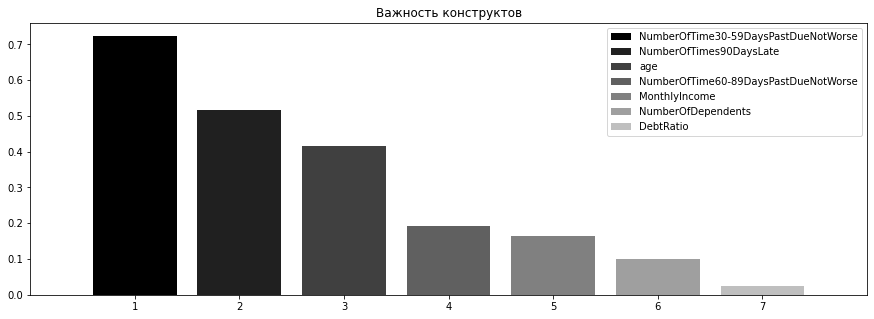

In [120]:
importances = coefs
indices = np.argsort(importances)[::-1]
num_to_plot = 7
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

for f in range(num_to_plot):
    print("%d. %s %f " % (f + 1, features[f], coefs[f]))
    
plt.figure(figsize=(15,5))
plt.title(u"Важность конструктов")
bars = plt.bar(range(num_to_plot), 
               results['coefs'],
       color=([str(i/float(num_to_plot+1)) 
               for i in range(num_to_plot)]),
               align="center")

ticks = plt.xticks(range(num_to_plot), 
                   feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [i
                  for i in features]);

**Ответ:** самый важный признак - NumberOfTime30-59DaysPastDueNotWorse (0.723427)

**Задание 6.** Посчитайте долю влияния DebtRatio на предсказание. (Воспользуйтесь функцией [softmax](https://en.wikipedia.org/wiki/Softmax_function))

In [165]:
from scipy.special import softmax

In [166]:
pd.DataFrame(softmax1(list(coefs)), features).T

,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate,age,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents,DebtRatio
0,0.210851,0.171488,0.155155,0.124124,0.120406,0.113201,0.104775


**Ответ:** 0.104775

**Задание 7.** 
Давайте посмотрим как можно интерпретировать влияние наших признаков. Для этого заного оценим логистическую регрессию в абсолютных величинах. После этого посчитайте во сколько раз увеличатся шансы, что клиент не выплатит кредит, если увеличить возраст на 20 лет при всех остальных равных значениях признаков. (теоретический расчет можно посмотреть [здесь](https://www.unm.edu/~schrader/biostat/bio2/Spr06/lec11.pdf))

${ \begin{array}{l}
Мы\ знаем,\ что\ формула\ логистической\ регрессии\ это:\\
\\
ln\left(\frac{p_{+}}{1-p_{+}}\right) =\beta _{0} \ +\ \beta _{1} x_{n} \ +\ ...\ +\ \beta _{n} x_{n}\\
\\
Избавимся\ от\ логарифма:\\
\\
\frac{p_{+}}{1-p_{+}} \ =\ e^{( \beta _{0} \ +\ \beta _{1} x_{1} \ +\ ...\ +\ \beta _{n} x_{n})} \ \ =\ e^{\beta } *\ e^{\beta _{1} x_{1}} *\ ...\ *\ e^{\beta _{n} x_{n}}\\
,\ это\ формула\ описывает\ исходную\ вероятность\ того,\ \\
что\ клиент\ не\ выплатит\ кредит.\\
\\
Тогда,\ формула\ того,\ что\ клиент\ не\ выплатит\ кредит,\ при\ увеличение\ возраста\ на\ 20\ лет,\\
при\ прочих\ равных\ значениях\ признаков\ ( пусть\ \beta _{1} \ -\ коэффициент\ при\ возрасте) :\\
\\
\frac{p_{old+}}{1-p_{old+}} \ =\ e^{( \beta _{0} \ +\ \beta _{1}( x_{1} +20) \ +\ ...\ +\ \beta _{n} x_{n})} \ \ \ \ =\ e^{\beta } *\ e^{\beta _{1}( x_{1} +20)} *\ ...\ *\ e^{\beta _{n} x_{n}}\\
\\
Считаем,\ во\ сколько\ раз\ увеличаться\ шансы\ невыплаты\ кредита:\\
\\
\frac{e^{\beta } *\ e^{\beta _{1}( x_{1} +20)} *\ ...\ *\ e^{\beta _{n} x_{n}}}{e^{\beta } *\ e^{\beta _{1} x_{1}} *\ ...\ *\ e^{\beta _{n} x_{n}}} \ =\ e^{20*\beta _{1}}
\end{array}}$

In [179]:
log_reg = LogisticRegression(C=0.001, random_state=5, class_weight='balanced')
log_reg.fit(X, y);

In [181]:
results = pd.DataFrame({
    'features': independent_columns_names,
    'coefs': array(map(abs, log_reg.coef_.flatten().tolist()))
}).sort_values(by='coefs', ascending=False)

In [185]:
print(f"Шансы увеличаться в: {np.exp(20 * log_reg.coef_[0][0])}")

Шансы увеличаться в: 0.7663525381903354


**Ответ:** на ~77%

# Случайный лес

In [314]:
from sklearn.ensemble import RandomForestClassifier

# Инициализируем случайный лес с 100 деревьями и сбалансированными классами
rf = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=42,
    oob_score=True,
    class_weight="balanced",
)

## Будем искать лучшие параметры среди следующего набора
parameters = {
    "max_features": [1, 2, 4],
    "min_samples_leaf": [3, 5, 7, 9],
    "max_depth": [5, 10, 15],
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

gs = GridSearchCV(rf, param_grid=parameters, cv=skf, n_jobs=-1, scoring='roc_auc', refit=True, verbose=True)
gs.fit(X, y);

Fitting 5 folds for each of 36 candidates, totalling 180 fits


**Задание 8.** На сколько точность лучшей модели случайного леса выше точности логистической регрессии на валидации?

In [315]:
gs.best_params_

{'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 9}

In [322]:
rf_best_score = gs.best_score_
print(f'RF лучше на: {round((rf_best_score - lr_best_score)*100)}%')

RF лучше на: 3%


**Задание 9.** Определите какой признак имеет самое слабое влияние.

In [235]:
estimator.fit(X, y);

In [237]:
rf_results = pd.DataFrame({
    'features': independent_columns_names,
    'coefs': array(map(abs, estimator.feature_importances_.flatten().tolist()))
}).sort_values(by='coefs', ascending=False)

In [242]:
features, coefs = rf_results['features'].values, rf_results['coefs'].values

1. NumberOfTime30-59DaysPastDueNotWorse 0.217539 
2. NumberOfTimes90DaysLate 0.202943 
3. DebtRatio 0.168648 
4. age 0.147167 
5. MonthlyIncome 0.129112 
6. NumberOfTime60-89DaysPastDueNotWorse 0.107685 
7. NumberOfDependents 0.026907 


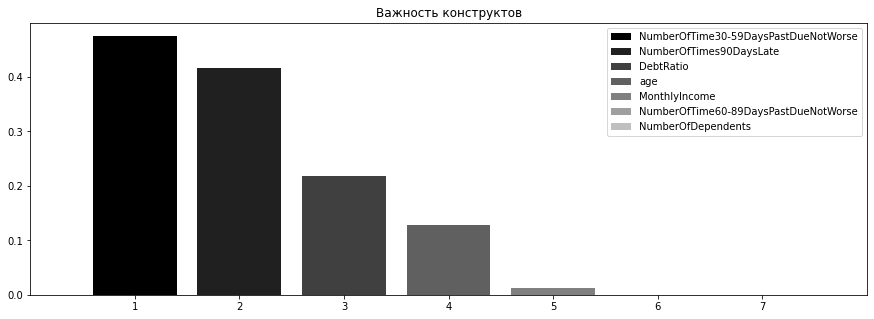

In [244]:
importances = coefs
indices = np.argsort(importances)[::-1]
num_to_plot = 7
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

for f in range(num_to_plot):
    print("%d. %s %f " % (f + 1, features[f], coefs[f]))
    
plt.figure(figsize=(15,5))
plt.title(u"Важность конструктов")
bars = plt.bar(range(num_to_plot), 
               results['coefs'],
       color=([str(i/float(num_to_plot+1)) 
               for i in range(num_to_plot)]),
               align="center")

ticks = plt.xticks(range(num_to_plot), 
                   feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [i
                  for i in features]);

**Ответ:** NumberOfDependents (0.026907) 

**Задание 10.** Какое наиболее существенное примущество логистической регрессии перед случайным лесом для нашей бизнес-задачи?

- меньше тратится времени для тренировки модели;
- меньше параметров для перебора;
- интепретируемость признаков;
- линейные свойства алгоритма.

**Ответ:** интепретируемость признаков

# Бэггинг

In [249]:
parameters = {
    "max_features": [2, 3, 4],
    "max_samples": [0.5, 0.7, 0.9],
    "base_estimator__C": [0.0001, 0.001, 0.01, 1, 10, 100],
}

**Задание 11.** Следующая задача обучить бэггинг классификатор (`random_state`=42). В качестве базовых классификаторов возьмите 100 логистических регрессий и на этот раз используйте не `GridSearchCV`, а `RandomizedSearchCV`. Так как перебирать все 54 варианта комбинаций долго, то поставьте максимальное число итераций 20 для `RandomizedSearchCV`. Также не забудьте передать параметр валидации `cv` и `random_state=1`. Какая лучшая точность получилась?

In [248]:
bc = BaggingClassifier(base_estimator=LogisticRegression(C=0.001, random_state=5, class_weight='balanced'),
                       n_estimators=100, n_jobs=None, random_state=42, verbose=True)

In [258]:
gs = RandomizedSearchCV(bc, n_iter=20, param_distributions=parameters,
                        cv=skf, n_jobs=-1, scoring='roc_auc', refit=True,
                        verbose=True, random_state=1)
gs_result = gs.fit(X, y);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s finished


In [264]:
print(f"Лучшая точность: {gs_result.best_score_}")

Лучшая точность: 0.8087951623513827


**Задача 12.** Дайте интерпретацию лучших параметров для бэггинга. Почему именно такие значения оказались лучшими?

- для бэггинга важно использовать как можно меньше признаков
- бэггинг лучше работает на небольших выборках
- меньше корреляция между одиночными моделями
- чем больше признаков, тем меньше теряется информации

In [266]:
print(f"Лучшие параметры: {gs_result.best_params_}")

Лучшие параметры: {'max_samples': 0.9, 'max_features': 2, 'base_estimator__C': 100}


**Ответ:** меньше корреляция между одиночными моделями, которая достигается за счет уменьшая корреляции в сэмплированных данных за счет выбора разных признаков и уменьшения корреляции таким образом(если бы выборки были похожи, то корреляция между моделями была бы очень большая, а значит и ответы были бы одинаковые, потому что в логистической регрессии практически нет случайности)